In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=30, num_layers=5, dropout=0.17044, num_classes=2):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.relu = nn.ReLU()
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Get the output from the last time step
        out = self.relu(out[:, -1, :])
        
        # FC layer
        out = self.fc(out)
        return out

In [5]:
# Define function to balance dataset
def balance_dataset(X, y):
    """
    Balance the dataset by upsampling the minority class
    """
    X_normal = X[y == 0]
    y_normal = y[y == 0]
    X_attack = X[y == 1]
    y_attack = y[y == 1]
    
    # Upsample minority class
    if len(X_attack) < len(X_normal):
        X_attack_upsampled, y_attack_upsampled = resample(
            X_attack, y_attack,
            replace=True,
            n_samples=len(X_normal),
            random_state=42
        )
        X_balanced = np.vstack((X_normal, X_attack_upsampled))
        y_balanced = np.hstack((y_normal, y_attack_upsampled))
    else:
        X_balanced = np.vstack((X_normal, X_attack))
        y_balanced = np.hstack((y_normal, y_attack))
    
    return X_balanced, y_balanced

In [18]:
# Define preprocessing function
def preprocess_data(df, sequence_length=20):
    """
    Preprocess the data including:
    - Handling missing values
    - Encoding categorical data
    - Scaling features
    - Creating sequences for LSTM
    """
    # Make a copy of the dataframe to avoid modifying the original
    df = df.copy()
    
    # Identify categorical columns
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Identify numerical columns (excluding the label column)
    numerical_cols = df.select_dtypes(include=['number']).columns.tolist()
    if 'label' in numerical_cols:
        numerical_cols.remove('label')
    
    # Handle missing values - separately for numerical and categorical columns
    if numerical_cols:
        df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].mean())
    
    if categorical_cols:
        for col in categorical_cols:
            df[col] = df[col].fillna(df[col].mode()[0])
    
    # One-hot encode categorical data
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    if categorical_cols:
        encoded_cats = encoder.fit_transform(df[categorical_cols])
        encoded_df = pd.DataFrame(encoded_cats, index=df.index)
        
        # Drop original categorical columns and join encoded ones
        df = df.drop(columns=categorical_cols)
        df = pd.concat([df, encoded_df], axis=1)
    
    # Scale numerical features
    scaler = StandardScaler()
    features = df.drop(columns=['label'], errors='ignore') if 'label' in df.columns else df
    df_scaled = scaler.fit_transform(features)
    
    # Create sequences
    X, y = [], []
    for i in range(len(df_scaled) - sequence_length):
        X.append(df_scaled[i:i+sequence_length])
        y.append(1 if 'label' in df.columns and df['label'].iloc[i+sequence_length] == 1 else 0)
    
    return np.array(X), np.array(y), scaler, encoder if categorical_cols else None

In [6]:
# Define training function
def train_model(model, train_loader, val_loader, epochs=59, lr=0.00676, device='cpu'):
    """
    Train the LSTM model with early stopping
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    # Early stopping parameters
    patience = 35
    best_val_acc = 0
    counter = 0
    best_model = None
    
    # For plotting
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    
    for epoch in range(epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_acc = 100 * correct / total
        avg_train_loss = train_loss/len(train_loader)
        train_losses.append(avg_train_loss)
        train_accs.append(train_acc)
        
        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        val_acc = 100 * correct / total
        avg_val_loss = val_loss/len(val_loader)
        val_losses.append(avg_val_loss)
        val_accs.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        
        # Early stopping
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict().copy()
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print(f'Early stopping at epoch {epoch+1}')
                break
    
    # Load best model
    if best_model:
        model.load_state_dict(best_model)
    
    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, label='Train Accuracy')
    plt.plot(val_accs, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    return model

In [7]:
# Define evaluation function
def evaluate_model(model, test_loader, device='cpu'):
    """
    Evaluate the model on the test set
    """
    model.eval()
    correct = 0
    total = 0
    
    # For confusion matrix
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions and labels for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = 100 * correct / total
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    true_neg, false_pos, false_neg, true_pos = cm.ravel()
    
    precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    print(f'Test Accuracy: {accuracy:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Normal', 'Anomaly'],
                yticklabels=['Normal', 'Anomaly'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(all_labels, all_preds, target_names=['Normal', 'Anomaly']))
    
    return accuracy, precision, recall, f1

In [8]:
# Define objective function for Optuna
def objective(trial):
    """
    Objective function for hyperparameter optimization
    """
    # Hyperparameters to optimize
    hidden_size = trial.suggest_int('hidden_size', 15, 70)
    num_layers = trial.suggest_int('num_layers', 1, 5)
    batch_size = trial.suggest_int('batch_size', 15, 400)
    dropout = trial.suggest_float('dropout', 0.1, 0.9)
    sequence_length = trial.suggest_categorical('sequence_length', [10, 20, 40, 60])
    lr = trial.suggest_float('lr', 0.001, 0.01)
    
    # Create model with suggested hyperparameters
    input_size = X_train.shape[2]
    model = LSTMModel(input_size, hidden_size, num_layers, dropout)
    model = model.to(device)
    
    # Create data loaders with suggested batch size
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    # Train model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(10):  # Reduced epochs for optimization
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    
    # Evaluate model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = correct / total
    return accuracy

In [9]:
# Load and explore data
# Replace this with your actual data loading code
# For example:
# df = pd.read_csv('your_dataset.csv')
print("Loading data...")

# For demonstration, let's create a synthetic dataset
# In a real notebook, you would load your actual data here
np.random.seed(42)
n_samples = 1000
n_features = 16

# Create synthetic features
features = ['orig', 'type', 'i/f_name', 'i/f_dir', 'src', 'dst', 'proto', 
            'appi_name', 'proxy_src_ip', 'Modbus_Function_Code', 
            'Modbus_Transaction_ID', 'service', 's_port', 'hour', 'minute', 'second']

# Create a synthetic DataFrame
df = pd.DataFrame(np.random.randn(n_samples, len(features)), columns=features)

# Add some categorical features
df['proto'] = np.random.choice(['TCP', 'UDP', 'ICMP'], n_samples)
df['service'] = np.random.choice(['HTTP', 'DNS', 'FTP', 'SSH'], n_samples)

# Add a label column (0 for normal, 1 for anomaly)
# Let's say 10% of the data are anomalies
df['label'] = np.random.choice([0, 1], n_samples, p=[0.9, 0.1])

# Display the first few rows of the dataset
print("Dataset preview:")
df.head()

Loading data...
Dataset preview:


,orig,type,i/f_name,i/f_dir,src,dst,proto,appi_name,proxy_src_ip,Modbus_Function_Code,Modbus_Transaction_ID,service,s_port,hour,minute,second,label
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,-0.234137,UDP,0.767435,-0.469474,0.542560,-0.463418,HTTP,0.241962,-1.913280,-1.724918,-0.562288,1
1,-1.012831,0.314247,-0.908024,-1.412304,1.465649,-0.225776,ICMP,-1.424748,-0.544383,0.110923,-1.150994,HTTP,-0.600639,-0.291694,-0.601707,1.852278,0
2,-0.013497,-1.057711,0.822545,-1.220844,0.208864,-1.959670,TCP,0.196861,0.738467,0.171368,-0.115648,FTP,-1.478522,-0.719844,-0.460639,1.057122,0
3,0.343618,-1.763040,0.324084,-0.385082,-0.676922,0.611676,TCP,0.931280,-0.839218,-0.309212,0.331263,SSH,-0.479174,-0.185659,-1.106335,-1.196207,0
4,0.812526,1.356240,-0.072010,1.003533,0.361636,-0.645120,UDP,1.538037,-0.035826,1.564644,-2.619745,HTTP,0.087047,-0.299007,0.091761,-1.987569,1


In [10]:
# Data exploration
print("\nDataset shape:", df.shape)
print("\nData types:")
df.dtypes


Dataset shape: (1000, 17)

Data types:


orig                     float64
type                     float64
i/f_name                 float64
i/f_dir                  float64
src                      float64
dst                      float64
proto                     object
appi_name                float64
proxy_src_ip             float64
Modbus_Function_Code     float64
Modbus_Transaction_ID    float64
service                   object
s_port                   float64
hour                     float64
minute                   float64
second                   float64
label                      int64
dtype: object

In [11]:
# Check for missing values
print("\nMissing values:")
df.isnull().sum()


Missing values:


orig                     0
type                     0
i/f_name                 0
i/f_dir                  0
src                      0
dst                      0
proto                    0
appi_name                0
proxy_src_ip             0
Modbus_Function_Code     0
Modbus_Transaction_ID    0
service                  0
s_port                   0
hour                     0
minute                   0
second                   0
label                    0
dtype: int64

In [12]:
# Class distribution
print("\nClass distribution:")
df['label'].value_counts()


Class distribution:


label
0    894
1    106
Name: count, dtype: int64

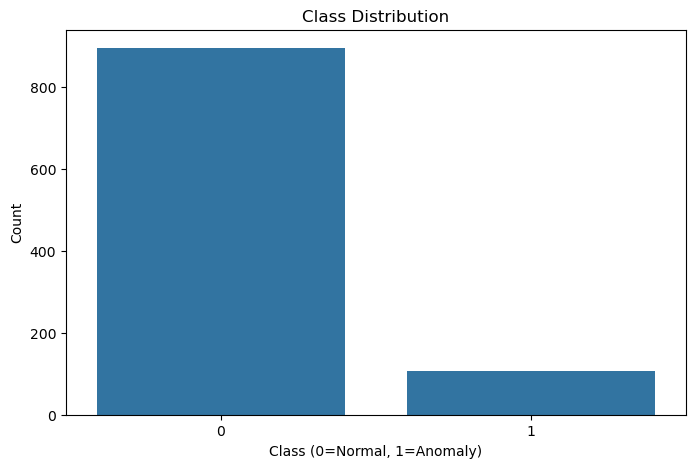

In [13]:
# Visualize class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.xlabel('Class (0=Normal, 1=Anomaly)')
plt.ylabel('Count')
plt.show()

In [19]:
# Preprocess data
print("\nPreprocessing data...")
sequence_length = 20
X, y, scaler, encoder = preprocess_data(df, sequence_length=sequence_length)

print(f"X shape: {X.shape}, y shape: {y.shape}")
print(f"Class distribution in y: {np.bincount(y)}")


Preprocessing data...


TypeError: Feature names are only supported if all input features have string names, but your input has ['int', 'str'] as feature name / column name types. If you want feature names to be stored and validated, you must convert them all to strings, by using X.columns = X.columns.astype(str) for example. Otherwise you can remove feature / column names from your input data, or convert them all to a non-string data type.

In [ ]:
# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")

In [ ]:
# Balance the training data
print("\nBalancing dataset...")
X_train_balanced, y_train_balanced = balance_dataset(X_train, y_train)
print(f"Balanced training set: {X_train_balanced.shape}, {y_train_balanced.shape}")
print(f"Class distribution after balancing: {np.bincount(y_train_balanced)}")

In [ ]:
# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")

In [ ]:
# Hyperparameter optimization with Optuna
print("\nStarting hyperparameter optimization...")
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)  # Reduced for demonstration, use 100 for full optimization

best_params = study.best_params
print(f"\nBest hyperparameters: {best_params}")

In [ ]:
# Create model with best hyperparameters
input_size = X_train.shape[2]
model = LSTMModel(
    input_size=input_size,
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    dropout=best_params['dropout']
)
model = model.to(device)

# Create data loaders
batch_size = best_params['batch_size']
train_dataset = TensorDataset(torch.FloatTensor(X_train_balanced), torch.LongTensor(y_train_balanced))
val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.LongTensor(y_val))
test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
# Train model
print("\nTraining model...")
model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    epochs=59,  # As specified in the document
    lr=best_params['lr'],
    device=device
)

In [ ]:
# Evaluate model
print("\nEvaluating model...")
accuracy, precision, recall, f1 = evaluate_model(model, test_loader, device)

In [ ]:
# Save model and preprocessing objects
print("\nSaving model and preprocessing objects...")
torch.save(model.state_dict(), 'lstm_anomaly_detection_model.pth')

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

if encoder:
    with open('encoder.pkl', 'wb') as f:
        pickle.dump(encoder, f)

print("\nDone!")